In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objs as go
import plotly
plotly.__version__

'4.5.0'

In [2]:
sns.set(style='darkgrid')
mpl.rcParams['figure.figsize'] = (12,15)

In [3]:
dataPath_Raw = ("data/COVID_Flat_Table_Complete.csv")
#dataPath_Processed = ("../data/processed/")

pd.set_option("display.max_rows", 500)

In [4]:
df_analyse = pd.read_csv(dataPath_Raw, sep=",")
df_analyse.sort_values('date', ascending = True).tail()

,date,Italy,US,Spain,Germany,India,"Korea, South",China,Brazil,Afghanistan,...,Burundi,Sierra Leone,Malawi,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho
145,2020-06-15,237290,2114026,244109,187682,343091,12155,84378,888271,25527,...,85,1176,555,1693,9,662,844,176,5097,4
146,2020-06-16,237500,2137731,244328,188252,354065,12198,84422,923189,26310,...,104,1225,564,1776,9,671,885,197,5160,4
147,2020-06-17,237828,2163290,244683,188604,366946,12257,84458,955377,26874,...,104,1249,572,1813,9,683,902,197,5221,4
148,2020-06-18,238159,2191052,245268,189817,380532,12306,84494,978142,27532,...,104,1272,592,1830,9,688,909,210,5279,4
149,2020-06-19,238011,2220961,245575,190299,395048,12373,84494,1032913,27878,...,104,1298,620,1864,9,693,919,210,5338,4


## Fitting

In [5]:
from scipy import optimize
from scipy import integrate

In [608]:
ydata = np.array(df_analyse.India[120:])   #90
time = np.arange(len(ydata))

In [609]:
N0 = 1000000
beta = 0.4
gamma = 0.1

I0 = ydata[0]
S0 = N0 - I0
R0 = 0

In [610]:
print(I0)

118226


In [611]:
def SIR_model_fit(SIR, time, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [612]:
def fit_odeint(x,beta,gamma):
    return integrate.odeint(SIR_model_fit, (S0,I0,R0), time, args=(beta, gamma))[:,1]

# [,:1] infected rate

In [613]:
# Integrate

popt = [0.4, 0.1]  #beta, gamma

fit_odeint(time, *popt);

In [614]:
popt, pcov = optimize.curve_fit(fit_odeint, time, ydata)
perr = np.sqrt(np.diag(pcov))


In [615]:
print('Standard deviation errors : ', str(perr), 'Infection Start : ', ydata[0])


Standard deviation errors :  [1.21690954e-04 5.75978587e-05] Infection Start :  118226


In [616]:
fitted = fit_odeint(time, *popt)
fitted

array([118226.        , 123986.27893122, 129989.02908662, 136240.71760642,
       142747.61654081, 149515.75994355, 156550.89863443, 163858.45252993,
       171443.46083075, 179310.53035449, 187463.78230773, 195906.79785761,
       204642.56298693, 213673.41307687, 223000.97773548, 232626.1266151 ,
       242548.91579961, 252768.53891053, 263283.27845488, 274090.46237402,
       285186.42547406, 296566.47440917, 308224.86171798, 320154.76355069,
       332348.26779091, 344796.36907851, 357488.97189048, 370414.90397194,
       383561.94224161, 396916.84425756])

In [617]:
popt, pcov = optimize.curve_fit(fit_odeint, time, ydata)
perr = np.sqrt(np.diag(pcov))


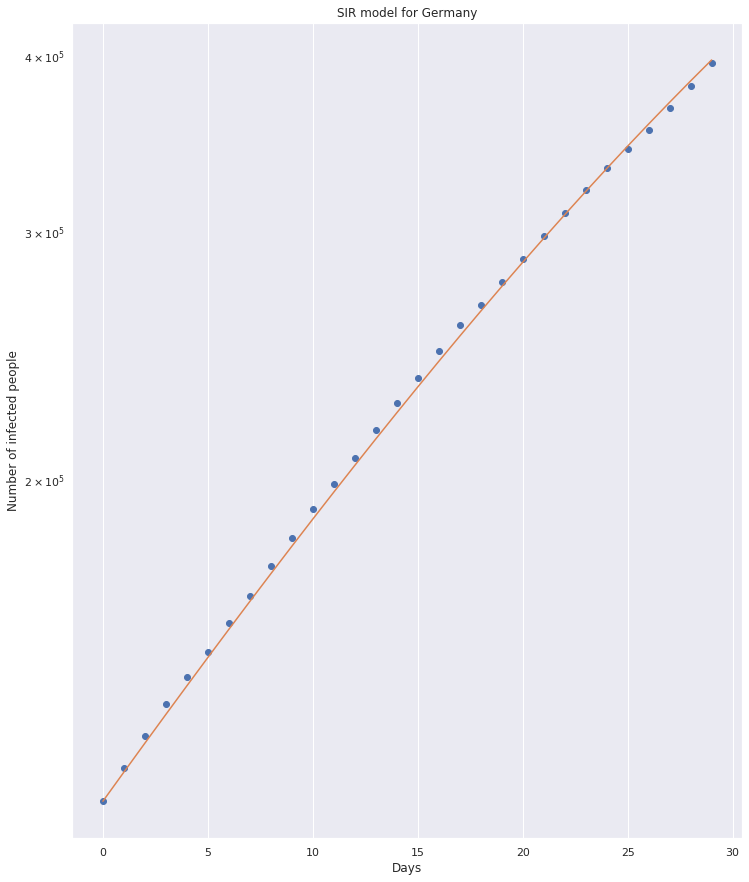

Optimal Parameters : beta =  0.05199252788712444 gamma =  -0.0018700690655557481
Reproduction number, R0 :  -27.80246400775218


In [618]:
plt.semilogy(time, ydata, 'o')                 #true data
plt.semilogy(time, fitted)                     #fitted data
plt.title('SIR model for Germany')
plt.ylabel('Number of infected people')
plt.xlabel('Days')
plt.show()

print('Optimal Parameters : beta = ', popt[0], 'gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

## Dynamic Beta 

In [592]:
t_initial = 15
t_intro_measures = 14
t_hold = 21
t_relax = 0

beta_max = popt[0]
beta_min = 0.11
gamma = popt[1]


pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max, beta_min, t_intro_measures),
                          np.array(t_hold * [beta_min]),
                          np.linspace(beta_min, beta_max, t_relax)
                        ))

pd_beta

array([0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 ,
       0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 ,
       0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 , 0.2150165 ,
       0.2150165 , 0.20693831, 0.19886012, 0.19078192, 0.18270373,
       0.17462554, 0.16654735, 0.15846915, 0.15039096, 0.14231277,
       0.13423458, 0.12615638, 0.11807819, 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ])

In [593]:
def SIR_model(SIR, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])

In [594]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each_beta in pd_beta:
    new_delta_vector = SIR_model(SIR, each_beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



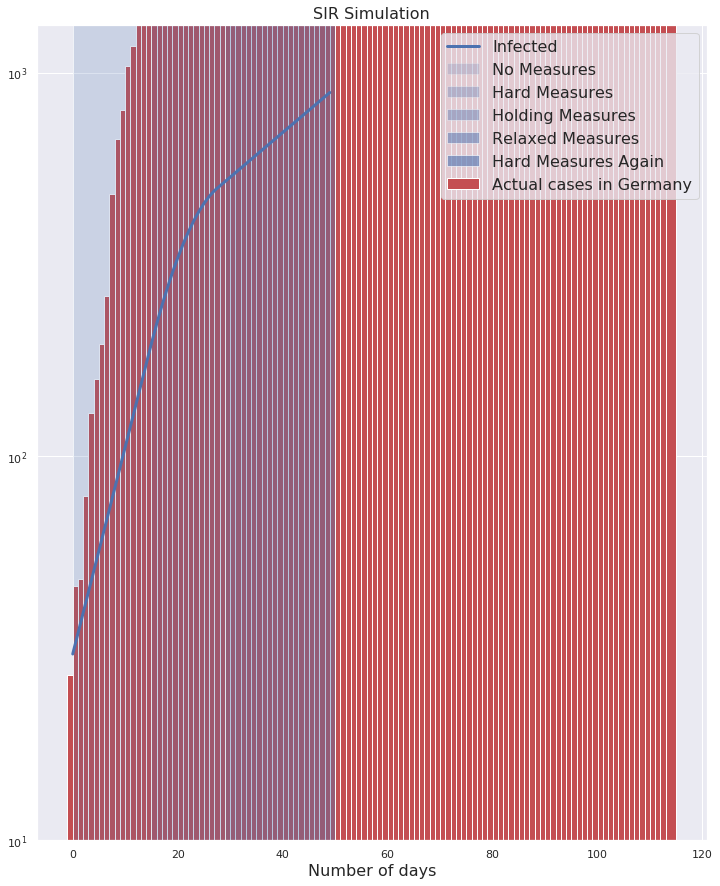

In [595]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', linewidth = 3)
#ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
#ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.bar(np.arange(len(ydata)), ydata, width=2, label = 'Actual cases in Germany', color = 'r')
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

ax1.axvspan(0, t_phases[0], facecolor='b', alpha=0.2, label="No Measures")
ax1.axvspan(t_phases[0], t_phases[1], facecolor='b', alpha=0.3, label="Hard Measures")
ax1.axvspan(t_phases[1], t_phases[2], facecolor='b', alpha=0.4, label="Holding Measures")
ax1.axvspan(t_phases[2], t_phases[3], facecolor='b', alpha=0.5, label="Relaxed Measures")
ax1.axvspan(t_phases[3], len(propagation_rates.Infected),facecolor='b', alpha=0.6, label="Hard Measures Again")

ax1.set_ylim(10,1.5*max(propagation_rates.Infected))
#ax1.set_xlim(0,100)
ax1.set_yscale('log')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})